In [1]:
# LOAD PACKAGES
from scipy.spatial.transform import Rotation as R
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings; warnings.simplefilter('ignore')
from matplotlib.lines import Line2D
from scipy.signal import butter, filtfilt
from scipy.optimize import differential_evolution
from scipy.optimize import minimize
import time
from concurrent.futures import ProcessPoolExecutor
import dask.dataframe as dd
from numba import njit
plt.rcParams['figure.dpi'] = 150

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# LOAD THE DATA
df1_raw = pd.read_table('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1_continuous_export_split#3.txt.txt')
df2_raw = pd.read_table('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1_continuous_export_split#4.txt.txt')
df3_raw = pd.read_table('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1_continuous_export_split#5.txt.txt')
gps = pd.read_csv('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1.GPS.UTM.csv')

In [3]:
# Merge ACC datasets
df_raw = pd.concat([df1_raw, df2_raw], ignore_index=True)
df_raw = pd.concat([df_raw,df3_raw],ignore_index=True)

In [4]:
df_raw.dtypes

Total Event no.        int64
Acc_x                float64
Acc_y                float64
Acc_z                float64
Mag_x                float64
Mag_y                float64
Mag_z                float64
Date                  object
DD                     int64
MM                     int64
YY                     int64
Time hh:mm:ss.ddd     object
Decimal secs         float64
Unnamed: 13          float64
dtype: object

In [5]:
# Convert date and time from text to datetime obj
df_raw['date_converted'] = pd.to_datetime(df_raw['Date'], format='%d/%m/%Y', errors='coerce')
df_raw['time_converted'] = pd.to_timedelta(df_raw['Time hh:mm:ss.ddd'])
df_raw['datetime'] = df_raw['date_converted'] + df_raw['time_converted']

gps['date_converted'] = pd.to_datetime(gps['Date'], format='%d/%m/%Y', errors='coerce')
gps['time_converted'] = pd.to_timedelta(gps['Time'])
gps['datetime'] = gps['date_converted'] + gps['time_converted']


In [6]:
df_raw.dtypes

Total Event no.                int64
Acc_x                        float64
Acc_y                        float64
Acc_z                        float64
Mag_x                        float64
Mag_y                        float64
Mag_z                        float64
Date                          object
DD                             int64
MM                             int64
YY                             int64
Time hh:mm:ss.ddd             object
Decimal secs                 float64
Unnamed: 13                  float64
date_converted        datetime64[ns]
time_converted       timedelta64[ns]
datetime              datetime64[ns]
dtype: object

In [7]:
# Select Columns
df_raw = df_raw[['Acc_x',
        'Acc_y',
        'Acc_z',
        'datetime']]



In [8]:
# Merge GPS and activity data
df_raw = pd.merge(df_raw,gps,on='datetime',how='left')

In [9]:
df_raw['datetime'].max()

Timestamp('2019-02-28 13:13:38')

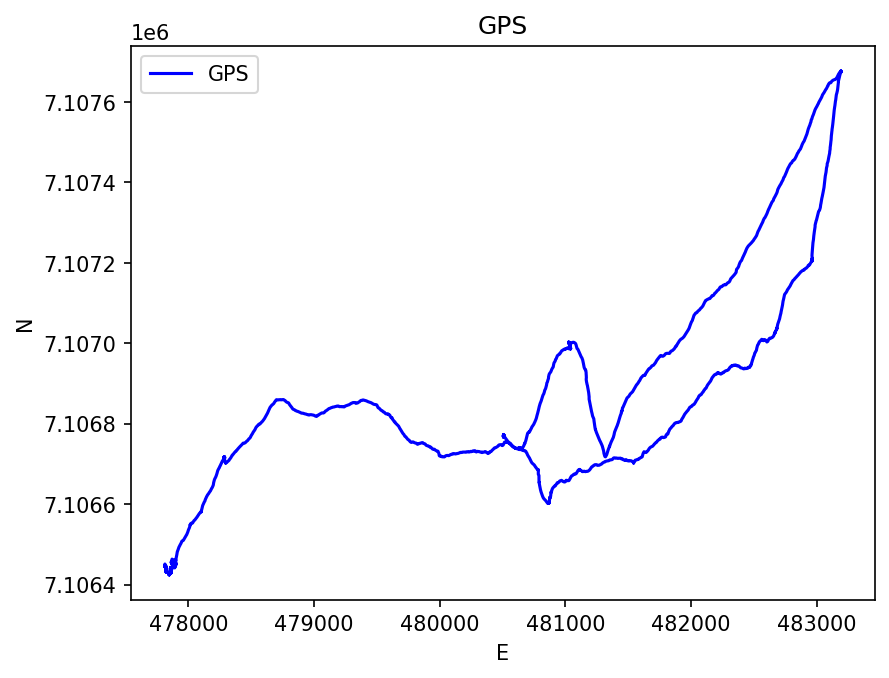

In [10]:
# PLOT GPS OVER TIME
# Calculate distance traveled during GPS track using the euclidean distance formula on each step
start_time = '2019-02-26 03:00:00'
end_time = '2019-02-26 09:00:00'

gps_pts = df_raw.copy()[(df_raw['datetime'] >= start_time) & (df_raw['datetime'] <= end_time)][df_raw['UTM_E'].notnull()]

x = gps_pts['UTM_E']
y = gps_pts['UTM_N']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(x, y,  color='b', label='GPS')

# Setting labels
ax.set_xlabel('E')
ax.set_ylabel('N')

# Adding a title and legend
ax.set_title('GPS')
ax.legend()

# Show plot
plt.show()

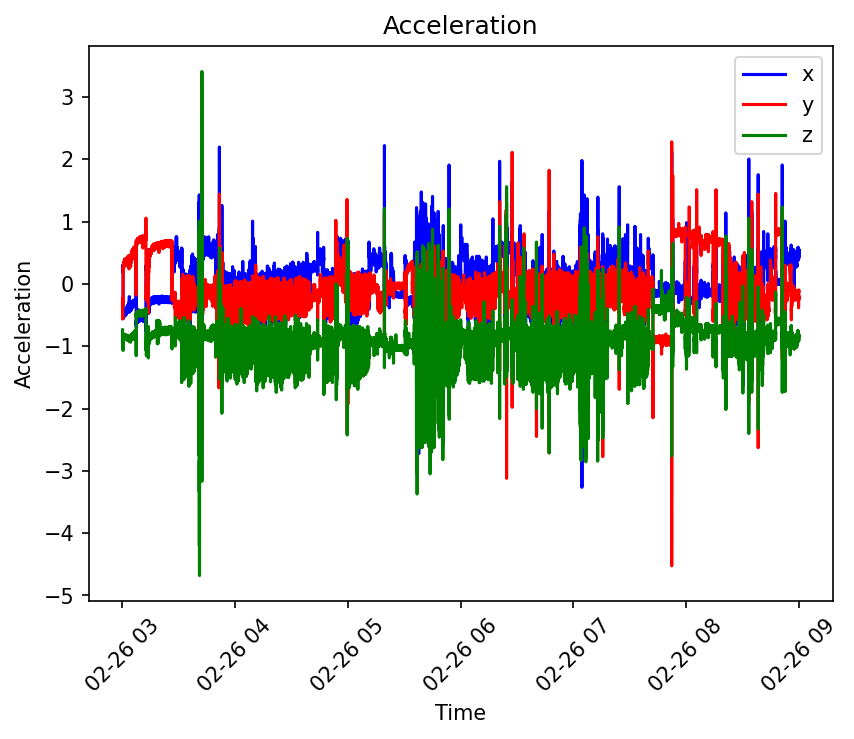

In [11]:
df = df_raw.copy()[(df_raw['datetime'] >= start_time) & (df_raw['datetime'] <= end_time)].reset_index()

# PLOT ACCELERATION OVER TIME
Acc_x = df['Acc_x']
Acc_y = df['Acc_y']
Acc_z = df['Acc_z']
dt = df['datetime']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dt, Acc_x, linestyle='-', color='b', label='x')
ax.plot(dt, Acc_y,  linestyle='-', color='r', label='y')
ax.plot(dt, Acc_z,  linestyle='-', color='g', label='z')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Adding a title and legend
ax.set_title('Acceleration')
ax.legend()

# Show plot
plt.show()

## 1) Remove effects of pitch and roll

Static acceleration is estimated using a 4th order zero phase low pass butterworth filter with wc = 0.1 Hz following Ladha et al. 2018 (BMC Veterinary Research). 

In [12]:
# DESIGN THE BUTTERWORTH FILTER

# Parameters
order = 4  # 4th order
cutoff_frequency = 0.5  # Cutoff frequency in Hz
sampling_rate = 10 # Sampling rate in Hz (adjust as needed)

# Normalized cutoff frequency (as a fraction of the Nyquist frequency)
nyquist_frequency = 0.5 * sampling_rate
normalized_cutoff = cutoff_frequency / nyquist_frequency

# Get the filter coefficients
b, a = butter(order, normalized_cutoff, btype='low', analog=False)

In [13]:
# APPLY THE FILTER TO CALCULATE STATIC ACCELERATION

df['Gx'] = filtfilt(b, a, df['Acc_x'])
df['Gy'] = filtfilt(b, a, df['Acc_y'])
df['Gz'] = filtfilt(b, a, df['Acc_z'])

# Calculate Dynamic Acceleration
df['DAx'] = df['Acc_x'] - df['Gx']
df['DAy'] = df['Acc_y'] - df['Gy']
df['DAz'] = df['Acc_z'] - df['Gz']

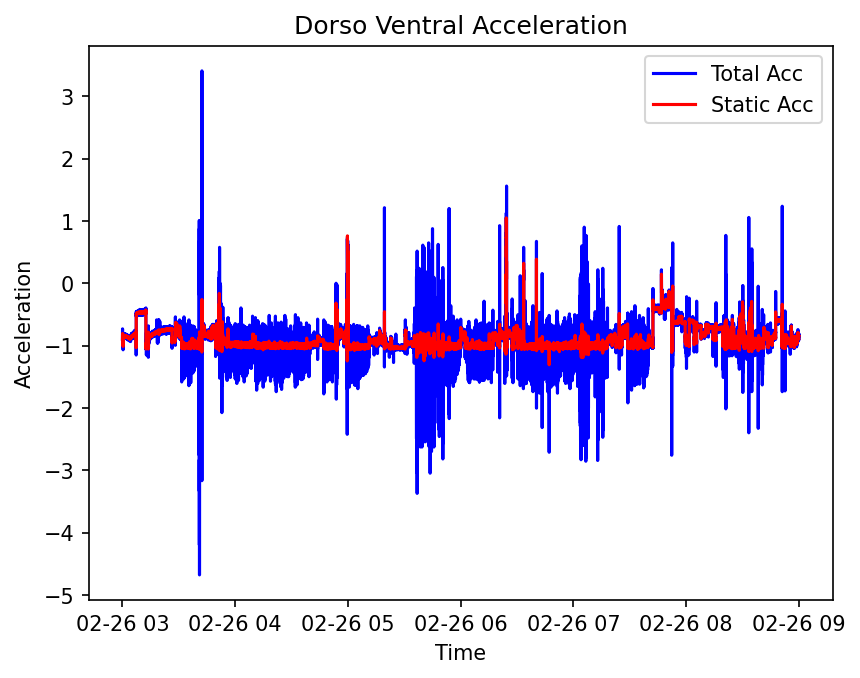

In [14]:
# PLOT STATIC ACCLERATION
Acc_z = df['Acc_z']
Gz = df['Gz']
dt = df['datetime']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dt, Acc_z,  linestyle='-', color='b', label='Total Acc')
ax.plot(dt, Gz,  linestyle='-', color='r', label='Static Acc')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')

# Adding a title and legend
ax.set_title('Dorso Ventral Acceleration')
ax.legend()

# Show plot
plt.show()

In [15]:
# Get static acceleration
Gx = np.array(df['Gx'])
Gy = np.array(df['Gy'])
Gz = np.array(df['Gz'])

# Compute pitch (radians)
#pitch = np.arctan2(Gy,np.sqrt(Gx**2 + Gz**2))
pitch = np.arctan2(Gx,np.sqrt(Gy**2 + Gz**2))
df['pitch'] = pitch

# Compute roll (radians)
#roll =  np.arctan2(Gx,np.sqrt(Gy**2 + Gz**2))
roll =  np.arctan2(Gy,np.sqrt(Gx**2 + Gz**2))
df['roll'] = roll

In [16]:
# Get Rx
def get_Rx(pitch_values):
    cos_pitch = np.cos(pitch_values)
    sin_pitch = np.sin(pitch_values)

    # Create an empty array to hold the rotation matrices
    # Shape: (n, 3, 3) where n is the number of pitch values
    rotation_matrices = np.zeros((pitch_values.shape[0], 3, 3))

    # Fill in the rotation matrices
    rotation_matrices[:, 0, 0] = 1  # First row, first column is always 1
    rotation_matrices[:, 1, 1] = cos_pitch  # cos(pitch) in second row, second column
    rotation_matrices[:, 1, 2] = sin_pitch  # sin(pitch) in second row, third column
    rotation_matrices[:, 2, 1] = -sin_pitch # -sin(pitch) in third row, second column
    rotation_matrices[:, 2, 2] = cos_pitch  # cos(pitch) in third row, third column

    return rotation_matrices

Rx = get_Rx(pitch)

# Get Ry
def get_Ry(roll_values):
    cos_roll = np.cos(roll_values)
    sin_roll = np.sin(roll_values)

    # Create an empty array to hold the rotation matrices
    # Shape: (n, 3, 3) where n is the number of roll values
    rotation_matrices = np.zeros((roll_values.shape[0], 3, 3))

    # Fill in the rotation matrices
    rotation_matrices[:, 0, 0] = cos_roll  # cos(roll) in first row, first column
    rotation_matrices[:, 0, 2] = sin_roll  # sin(roll) in first row, third column
    rotation_matrices[:, 1, 1] = 1         # 1 in the second row, second column
    rotation_matrices[:, 2, 0] = -sin_roll # -sin(roll) in third row, first column
    rotation_matrices[:, 2, 2] = cos_roll  # cos(roll) in third row, third column

    return rotation_matrices

Ry = get_Ry(roll)

# Get array of raw acceleration
Acc = np.asarray(df[['Acc_x','Acc_y','Acc_z']])

# Remove the effects of pitch by multiplying the accelerometer data by the pitch rotation matrices
pitch_corrected_data = np.einsum('ijk,ik->ij', Rx, Acc)

# Remove the effects of roll by multiplying the pitch-corrected data by the roll rotation matrices
pitch_and_roll_corrected_data = np.einsum('ijk,ik->ij', Ry,pitch_corrected_data)

# Convert from numpy to pandas and add the data to the "df" dataframe
rotated_data = pitch_and_roll_corrected_data
rotated_data_df = pd.DataFrame(rotated_data, columns=['RAx', 'RAy', 'RAz'])
df['RAx'] = rotated_data_df['RAx']
df['RAy'] = rotated_data_df['RAy']
df['RAz'] = rotated_data_df['RAz']

In [17]:
Acc.shape

(215963, 3)

In [18]:
# # ROTATE DATA

# # Build rotation function
# def rotate_data(row):
#     pitch = row['pitch']
#     roll = row['roll']
#     Rx = np.array([[1,0,0],
#           [0,math.cos(pitch),math.sin(pitch)],
#           [0,-math.sin(pitch),math.cos(pitch)]])
#     Ry = np.array([[math.cos(roll),0,-math.sin(roll)],
#          [0,1,0],
#          [math.sin(roll),0,math.cos(roll)]])
#     Ax = row['Acc_x']
#     Ay = row['Acc_y']
#     Az = row['Acc_z']
#     A = np.array([[Ax],[Ay],[Az]])
#     RA = Ry @ Rx @ A
#     row['RAx'] = RA[0]
#     row['RAy'] = RA[1]
#     row['RAz'] = RA[2]
#     return row

# # Initialize columns
# df['RAx'] = -999
# df['RAy'] = -999
# df['RAz'] = -999

# # Rotate data
# df = df.apply(rotate_data,axis=1)

## Identify movement periods using magnitude threshold

In [19]:
# DESIGN THE BUTTERWORTH FILTER
# Purpose of this butterworth filter is to filter out noise in the Acc data

# Parameters
order = 4  # 4th order
cutoff_frequency = 4.75  # Cutoff frequency in Hz (Wc). Here 
sampling_rate = 10  # Sampling rate in Hz (adjust as needed)

# Normalized cutoff frequency (as a fraction of the Nyquist frequency)
nyquist_frequency = 0.5 * sampling_rate
normalized_cutoff = cutoff_frequency / nyquist_frequency

# Get the filter coefficients
b, a = butter(order, normalized_cutoff, btype='low', analog=False)

In [20]:
# APPLY THE FILTER TO ROTATED DATA
df['FRAx'] = filtfilt(b, a, df['RAx'])
df['FRAy'] = filtfilt(b, a, df['RAy'])
df['FRAz'] = filtfilt(b, a, df['RAz'])

In [21]:
# Compute magnitude of acceleration vector
df['FRAx'] = pd.to_numeric(df['FRAx'], errors='coerce')
df['FRAy'] = pd.to_numeric(df['FRAy'], errors='coerce')
df['FRAz'] = pd.to_numeric(df['FRAz'], errors='coerce')
df['magnitude'] = np.sqrt(df['FRAx']**2 + df['FRAy']**2 + df['FRAz']**2)

# Define a threshold for classifying activity based on standard deviation
sd_threshold = 0.01 # standard deviation

# Calculate standard deviation of magnitude of acceleration using a rolling window
window_size = 50 # 5 Seconds
df['mag_sd'] = df['magnitude'].rolling(window=window_size).std()

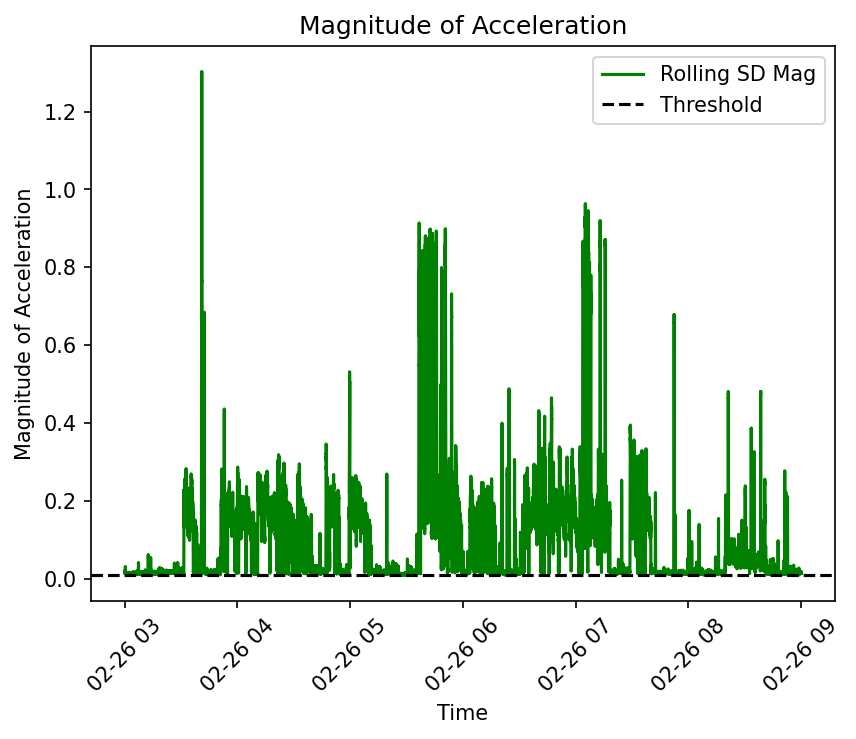

In [22]:
# Plot magnitude vs time
mag = df['magnitude']
dt = df['datetime']
mag_std = df['mag_sd']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
#ax.plot(dt, mag, linestyle='-', color='b', label='Magnitude Acc')
ax.plot(dt,mag_std,linestyle="-", color = "g", label = "Rolling SD Mag")
plt.axhline(y=sd_threshold, color='black', linestyle='--', label='Threshold')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude of Acceleration')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Adding a title and legend
ax.set_title('Magnitude of Acceleration')
ax.legend()

# Show plot
plt.show()

In [23]:
# Split activity periods into groups based on SD threshold
above_sd_threshold = np.array(df['mag_sd']) > sd_threshold
sd_threshold_change = np.append([False],above_sd_threshold[:-1] != above_sd_threshold[1:])
activity_group = np.cumsum(sd_threshold_change)
df['activity_group'] = activity_group

# Assign activity status based on SD threshold
df['active'] = above_sd_threshold

# Get rid of small groups (activity periods < 20s)
group_counts = df.groupby('activity_group').size().reset_index(name='Count')
small_groups = group_counts.loc[group_counts['Count']<=200,'activity_group'].values
df.loc[df['activity_group'].isin(small_groups), 'active'] = 0

In [24]:
active_periods = df.copy()[df['active']==1].reset_index()

## Identify candidate steps using dynamic threshold on filtered DV axis

In [25]:
# Set the timestamp as the index
active_periods.set_index('datetime', drop = False, inplace = True) 

# Initialize zero threshold column
active_periods['thresh_z'] = -999

# Initialize falling flank column
active_periods['falling_edges'] = False

In [26]:
# Get a list of activity groups

activity_groups = active_periods.loc[active_periods['active']==1,'activity_group'].unique()
num_groups = len(activity_groups)

# Derive zero threshold for each activity group using 20s windows

for i in range(0,num_groups):
    
    # get group number
    group = activity_groups[i]
    
    # get group data
    group_data = active_periods[active_periods['activity_group'] == group]
    
    # calculate zero threshold
    for window_start in group_data.resample('20S').groups:
    
        window_data = group_data.loc[window_start:window_start + pd.Timedelta(seconds=20)]
    
        # Identify mean of max peak and min nadir in each window for acc in z axis
        signal = window_data['FRAz'].values
        max_z = signal.max()
        min_z = signal.min()
        thresh = (max_z + min_z)/2
        window_data['thresh_z'] = thresh
    
        # Identify falling flanks that cross the zero threshold 
        
        falling_edges = (signal[:-1] > thresh) & (signal[1:] <= thresh)
        window_data['falling_edges'].iloc[1:] = falling_edges
    
        group_data.loc[window_start:window_start + pd.Timedelta(seconds=20)] = window_data

    # Join group data back to complete dataset
    active_periods[active_periods['activity_group'] == group] = group_data
    

In [27]:
# # DERIVE ZERO THRESHOLD USIng 20s WINDOWS

# # Set the timestamp as the index
# df.set_index('datetime', drop = False, inplace = True) 

# # Initialize zero threshold column
# df['thresh_z'] = -999

# # Initialize falling flank column
# df['falling_edges'] = False

# for window_start in df.resample('20S').groups:

#     window_data = df.loc[window_start:window_start + pd.Timedelta(seconds=20)]

#     # Identify mean of max peak and min nadir in each window for acc in z axis
#     signal = window_data['FRAz'].values
#     max_z = signal.max()
#     min_z = signal.min()
#     thresh = (max_z + min_z)/2
#     window_data['thresh_z'] = thresh

#     # Identify falling flanks that cross the zero threshold 
    
#     falling_edges = (signal[:-1] > thresh) & (signal[1:] <= thresh)
#     window_data['falling_edges'].iloc[1:] = falling_edges

#     df.loc[window_start:window_start + pd.Timedelta(seconds=20)] = window_data
    

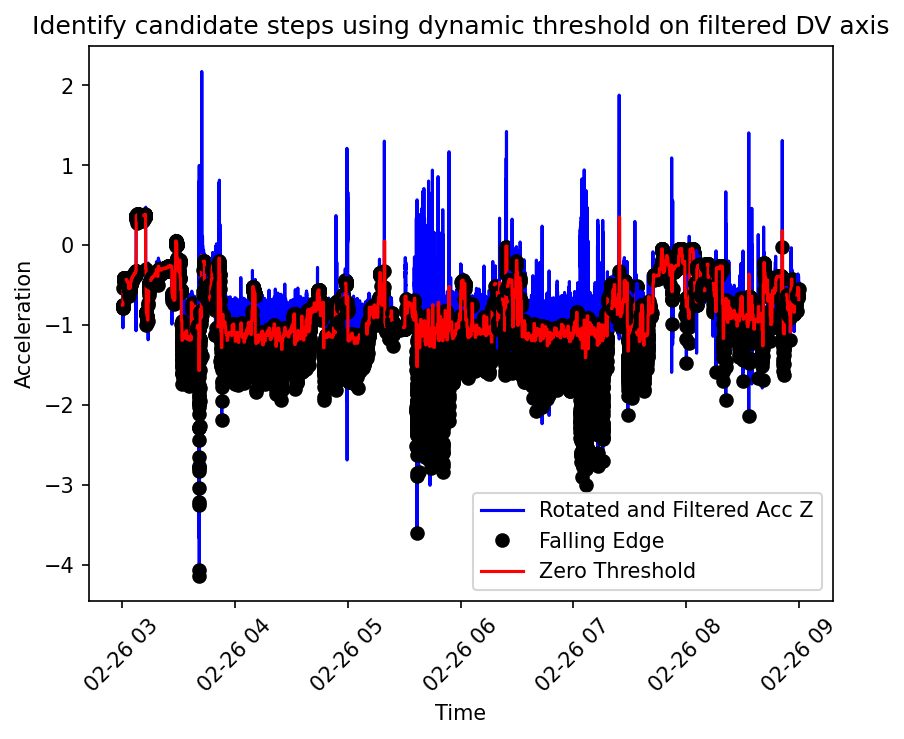

In [28]:
# Create plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add data by group
for i in range(0,num_groups):

    # get group number
    group = activity_groups[i]
    
    # get group data
    group_data = active_periods[active_periods['activity_group'] == group]
    
    # Get data for plotting
    FRAz = group_data['FRAz']
    thresh_z = group_data['thresh_z']
    dt = group_data['datetime']
    dt_falling_edges = group_data[active_periods['falling_edges'] == True]['datetime']
    falling_edges = group_data[active_periods['falling_edges'] == True]['FRAz']

    # Plot the data
    ax.plot(dt, FRAz, linestyle='-', color='b', label='Rotated and Filtered Acc Z')
    ax.plot(dt_falling_edges, falling_edges, marker = "o",linestyle='', color='black', label='Falling Edge')
    ax.plot(dt, thresh_z,  linestyle='-', color='r', label='Zero Threshold')

    # Add legend
    if i == 0:
        ax.legend()

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')

# Adding a title and legend
ax.set_title('Identify candidate steps using dynamic threshold on filtered DV axis')

# Show plot
plt.show()


## Estimate distance traveled from GPS

In [29]:
# Distance traveled from GPS

# Define start and end pts of each step
x0 = gps_pts['UTM_E'].iloc[:-1].values
x1 = gps_pts['UTM_E'].iloc[1:].values
y0 = gps_pts['UTM_N'].iloc[:-1].values
y1 = gps_pts['UTM_N'].iloc[1:].values

# Calculate x1-x0 and y1-y0
x_diff = x1-x0
y_diff = y1-y0

# Compute (x1-x0)^2 and (y1-y0)^2
x_diff_sqr = x_diff*x_diff
y_diff_sqr = y_diff*y_diff

# Compute (x1-x0)^2 + (y1-y0)^2
xy_diff_sqr_sum = x_diff_sqr + y_diff_sqr

# Compute ((x1-x0)^2 + (y1-y0)^2)^0.5
euclidean_distance_step = [math.sqrt(x) for x in xy_diff_sqr_sum]
euclidean_distance_step = np.append([0],euclidean_distance_step)
gps_pts['euclidean_distance_step'] = euclidean_distance_step

# Add error bounds assuming gps error is 0.5m
error = 0.5
gps_dist_lwr = np.maximum(0, np.array(euclidean_distance_step) - 2 * error)
gps_dist_upr = np.array(euclidean_distance_step) + 2 * error

# Compute total distance travel
gps_pts['cum_dist'] = gps_pts['euclidean_distance_step'].cumsum()
gps_pts['cumsum_lwr'] = np.cumsum(gps_dist_lwr)
gps_pts['cumsum_upr'] = np.cumsum(gps_dist_upr)

## Filter steps based on valid step frequencies

In [30]:
# Initialize dataframe to store step candidates
cols = list(df.columns) + ['elapsed_time'] 
step_candidates = pd.DataFrame(columns=cols)


# Get step candidates from each activity period and append them to the step_candidates dataframe
for i in range(0,num_groups):
    
    # get group number
    group = activity_groups[i]
    
    # get group data
    group_data = active_periods[active_periods['activity_group'] == group]

    # Filter group data for step candidates
    step_candidates_by_group = group_data[group_data['falling_edges'] == True]

    # Compute time between candidates
    step_candidates_by_group['elapsed_time'] = step_candidates_by_group['datetime'].diff().apply(lambda x: x.total_seconds()) 

    # Populate 'activity_group' column of step_candidates dataframe
    step_candidates_by_group['activity_group'] = group

    # Join step candidates from each group to main step candidates table
    step_candidates = pd.concat([step_candidates,step_candidates_by_group],ignore_index=True)

In [31]:
# Reset indices of step_candidates and df
active_periods['rowID'] = range(0,len(active_periods))
step_candidates['rowID'] = range(0,len(step_candidates))
active_periods.set_index('rowID', inplace = True) 
step_candidates.set_index('rowID', inplace = True) 

In [32]:
# Optimize valid step frequency range

# def model_predictions(params, data):
#     global active_periods
#     global gps_pts
#     # Get parameters
#     min_stride_freq, max_stride_freq = params
#     min_period = 1 / max_stride_freq
#     max_period = 1 / min_stride_freq
    
#     # Filter out false steps based on range of valid step frequencies
#     obs_freq = np.array(data['elapsed_time'])
#     valid_steps = (obs_freq >= min_period) & (obs_freq <= max_period)
#     data['valid_step'] = valid_steps
    
#     # Filter valid steps
#     data = data[['valid_step', 'datetime', 'activity_group']]
#     data = data[data['valid_step']].reset_index(drop=True)
    
#     # Initialize distance traveled column
#     data['distance_traveled'] = np.nan
    
#     # Create a list of DataFrames, each one filtered by an activity group
#     dfs = [data[data['activity_group'] == group] for group in data['activity_group'].unique()]
    
#     # Create a Dask DataFrame from the list of pandas DataFrames
#     step_candidates_dask = dd.from_pandas(pd.concat(dfs), npartitions=len(dfs))
    
#     def calculate_distance(group_step_candidates, active_periods):
#         # Reset index to use standard indexing
#         group_step_candidates = group_step_candidates.reset_index(drop=True)
        
#         # Initialize 'distance_traveled' column
#         group_step_candidates['distance_traveled'] = np.nan
    
#         # Calculate start and end times for strides
#         start_times = group_step_candidates['datetime'].shift(1).dropna()
#         end_times = group_step_candidates['datetime'].shift(-1).dropna()
    
#         # Filter out stride data that has valid start and end times
#         valid_indices = ~start_times.isna() & ~end_times.isna()
#         start_times = start_times[valid_indices]
#         end_times = end_times[valid_indices]
    
#         def compute_distance(start_time, end_time):
#             stride_data = active_periods[(active_periods['datetime'] >= start_time) & (active_periods['datetime'] <= end_time)]
#             if stride_data.empty:
#                 return 0
#             max_acc = stride_data['RAz'].max()
#             min_acc = stride_data['RAz'].min()
#             return (max_acc - min_acc)**0.25
    
#         distances = [compute_distance(start, end) for start, end in zip(start_times, end_times)]
    
#         # Fill the distances into the group_step_candidates
#         group_step_candidates['distance_traveled'].iloc[1:-1] = distances
    
#         # Fill NaN values with 0
#         group_step_candidates['distance_traveled'] = group_step_candidates['distance_traveled'].fillna(0)
        
#         return group_step_candidates

#     # Define the meta DataFrame to ensure Dask knows the structure of the result
#     meta = data.iloc[:0]  # Empty dataframe with correct columns
    
#     # Apply the function to each group
#     # Ensure active_periods is passed explicitly as an argument
#     result_dask_df = step_candidates_dask.map_partitions(lambda df: calculate_distance(df, active_periods), meta=meta)
    
#     # Compute the result
#     result_df = result_dask_df.compute()
    
#     # Group by second and sum distances
#     result_df = result_df.groupby(pd.Grouper(key='datetime', freq='S')).agg({'distance_traveled': 'sum'}).reset_index()

#     # Inner join with GPS points
#     distances = pd.merge(result_df, gps_pts, on="datetime", how="inner")

#     return distances

# # Define the cost and objectie functions
# def cost_function(params, data):
#     dists = model_predictions(params, data)
#     predictions = dists['distance_traveled']
#     actual = dists['euclidean_distance_step']
#     residuals = actual - predictions
#     return np.sum((residuals)**2)

# def objective(params):
#     return cost_function(params,data)
    
# # Define parameter bounds for Differential Evolution (a type of genetic algorithm)
# bounds = [(0.5, 0.6), (2, 3)]  # cutoff frequency, sampling rate, collar angle
# data = step_candidates

# # Run differential evolution algorithm to estimate optimal parameter values
# result = differential_evolution(objective, bounds,maxiter=10)

# print(result.x)

In [33]:
active_periods

,level_0,index,Acc_x,Acc_y,Acc_z,datetime,Date,Time,location.lat,location.long,...,RAz,FRAx,FRAy,FRAz,magnitude,mag_sd,activity_group,active,thresh_z,falling_edges
rowID,,,,,,,,,,,,,,,,,,,,,
0,49,165617,0.203857,-0.527832,-0.827881,2019-02-26 03:00:04.875,NaN,NaN,NaN,NaN,...,-0.486506,0.532292,-0.694893,-0.490444,1.003367,0.019402,1,True,-0.747775,False
1,50,165618,0.215820,-0.515869,-0.827881,2019-02-26 03:00:05.000,26/02/2019,03:00:05,-26.158312,20.804961,...,-0.483518,0.548159,-0.682357,-0.479281,0.997897,0.018806,1,True,-0.747775,False
2,51,165619,0.215820,-0.515869,-0.815918,2019-02-26 03:00:05.076,NaN,NaN,NaN,NaN,...,-0.474092,0.539724,-0.679326,-0.478608,0.990884,0.018216,1,True,-0.747775,False
3,52,165620,0.203857,-0.515869,-0.827881,2019-02-26 03:00:05.179,NaN,NaN,NaN,NaN,...,-0.490368,0.539498,-0.679351,-0.485595,0.994172,0.017965,1,True,-0.747775,False
4,53,165621,0.215820,-0.503906,-0.827881,2019-02-26 03:00:05.282,NaN,NaN,NaN,NaN,...,-0.485876,0.549375,-0.669955,-0.490884,0.995801,0.017986,1,True,-0.747775,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212804,215958,381526,0.455811,-0.119873,-0.887939,2019-02-26 08:59:59.589,NaN,NaN,NaN,NaN,...,-0.682301,0.545900,-0.497353,-0.682125,1.005317,0.013381,189,True,-0.543984,False
212805,215959,381527,0.431885,-0.119873,-0.911865,2019-02-26 08:59:59.692,NaN,NaN,NaN,NaN,...,-0.706350,0.516952,-0.516161,-0.706788,1.016470,0.013395,189,True,-0.543984,False
212806,215960,381528,0.419922,-0.119873,-0.875977,2019-02-26 08:59:59.794,NaN,NaN,NaN,NaN,...,-0.675268,0.505154,-0.496439,-0.674561,0.978092,0.013858,189,True,-0.543984,False


In [34]:
# VALID STEP FREQUENCIES
min_stride_freq = 0.5
max_stride_freq = 1.95
min_period = 1/max_stride_freq
max_period = 1/min_stride_freq

In [35]:
# Filter out false steps based on range of valid step frequencies
obs_freq = np.array(step_candidates['elapsed_time'])
valid_steps = (obs_freq >= min_period) & (obs_freq<= max_period)
step_candidates['valid_step'] = valid_steps
step_candidates = step_candidates[['valid_step','datetime','activity_group']]
step_candidates = step_candidates[step_candidates['valid_step'] == True].reset_index()

In [36]:
# Join step candidates back to original df
active_periods = pd.merge(step_candidates[['valid_step','datetime']],active_periods,on = 'datetime', how='right')

## Estimate distance traveled 

In [37]:
# # Initialize distance column
# step_candidates['distance_traveled'] = 0

# start_time = time.time()

# # Identify start and end times of each stride
# start_times = step
# # Calculate distance traveled during steps within each activity group
# for i in range(0,num_groups):

#      # get group number
#     group = activity_groups[i]
    
#     # get group data
#     group_step_candidates = step_candidates.copy()[step_candidates['activity_group'] == group]

#     # Calculate distance traveled during steps in the current activity group
#     for k in range(1,len(group_step_candidates)-1):
        
#         # Identify the start and the end of the stride
#         start_of_stride = group_step_candidates.iloc[k-1]
#         t_start_of_stride = start_of_stride['datetime']
        
#         end_of_stride = group_step_candidates.iloc[k+1]
#         t_end_of_stride = end_of_stride['datetime']
    
#         # Filter for accelerometery data between the start and end of the stride
#         stride_data = active_periods[(active_periods['datetime'] >= t_start_of_stride) & (active_periods['datetime'] <= t_end_of_stride)]
#         active_periods.loc[(active_periods['datetime'] >= t_start_of_stride) & (active_periods['datetime'] <= t_end_of_stride),'valid_step'] = 1
    
#         # Get max and min acceleration
#         max_acc = stride_data['RAz'].max()
#         min_acc = stride_data['RAz'].min()
    
#         # Estimate distance
#         h = (max_acc - min_acc)**0.25
    
#         group_step_candidates['distance_traveled'].iloc[k+1]=h

#     # Join group_step_candidates back to main step candidates dataframe
#     step_candidates[step_candidates['activity_group'] == group] = group_step_candidates

# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Elapsed time: {elapsed_time:.6f} seconds")

# # Calculate cumulative distance traveled
# step_candidates['cum_dist'] = step_candidates['distance_traveled'].cumsum()

In [38]:
# Initialize distance traveled column
step_candidates['distance_traveled'] = np.nan

# Create a list of DataFrames, each one filtered by an activity group
dfs = [step_candidates[step_candidates['activity_group'] == group] for group in activity_groups]

# Create a Dask DataFrame from the list of pandas DataFrames
step_candidates_dask = dd.from_pandas(pd.concat(dfs), npartitions=len(dfs))

def calculate_distance(group_step_candidates, active_periods):
    # Reset index to use standard indexing
    group_step_candidates = group_step_candidates.reset_index(drop=True)
    
    # Initialize 'distance_traveled' column
    group_step_candidates['distance_traveled'] = np.nan

    # Calculate start and end times for strides
    start_times = group_step_candidates['datetime'].shift(1).dropna()
    end_times = group_step_candidates['datetime'].shift(-1).dropna()

    # Filter out stride data that has valid start and end times
    valid_indices = ~start_times.isna() & ~end_times.isna()
    start_times = start_times[valid_indices]
    end_times = end_times[valid_indices]

    def compute_distance(start_time, end_time):
        stride_data = active_periods[(active_periods['datetime'] >= start_time) & (active_periods['datetime'] <= end_time)]
        if stride_data.empty:
            return 0
        max_acc = stride_data['RAz'].max()
        min_acc = stride_data['RAz'].min()
        return (max_acc - min_acc)**0.25

    distances = [compute_distance(start, end) for start, end in zip(start_times, end_times)]

    # Fill the distances into the group_step_candidates
    group_step_candidates['distance_traveled'] = np.nan
    group_step_candidates.iloc[1:-1, group_step_candidates.columns.get_loc('distance_traveled')] = distances

    # Fill NaN values with 0
    group_step_candidates['distance_traveled'] = group_step_candidates['distance_traveled'].fillna(0)
    
    return group_step_candidates

# Define the meta DataFrame to ensure Dask knows the structure of the result
meta = step_candidates.iloc[:0]  # Empty dataframe with correct columns

# Apply the function to each group
# Ensure active_periods is passed explicitly as an argument
result_dask_df = step_candidates_dask.map_partitions(calculate_distance, active_periods, meta=meta)

# Compute the result
start_time = time.time()
result_df = result_dask_df.compute()
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.6f} seconds")
print(result_df)

# Fill in NaN distance_traveled with 0
result_df['distance_traveled'] = result_df['distance_traveled'].fillna(0)

# Calculate cumulative distance traveled
result_df['cum_dist'] = result_df['distance_traveled'].cumsum()
step_candidates = result_df 

Elapsed time: 10.889541 seconds
     rowID  valid_step                datetime activity_group  \
0        1        True 2019-02-26 03:00:09.384              1   
1        3        True 2019-02-26 03:00:10.756              1   
2        4        True 2019-02-26 03:00:11.384              1   
3        7        True 2019-02-26 03:00:12.675              1   
4       11        True 2019-02-26 03:00:14.658              1   
..     ...         ...                     ...            ...   
385  25563        True 2019-02-26 08:59:14.170            189   
386  25567        True 2019-02-26 08:59:16.175            189   
387  25568        True 2019-02-26 08:59:17.000            189   
388  25573        True 2019-02-26 08:59:19.179            189   
389  25574        True 2019-02-26 08:59:19.794            189   

     distance_traveled  
0             0.000000  
1             0.498210  
2             0.530362  
3             0.526842  
4             0.507634  
..                 ...  
385         

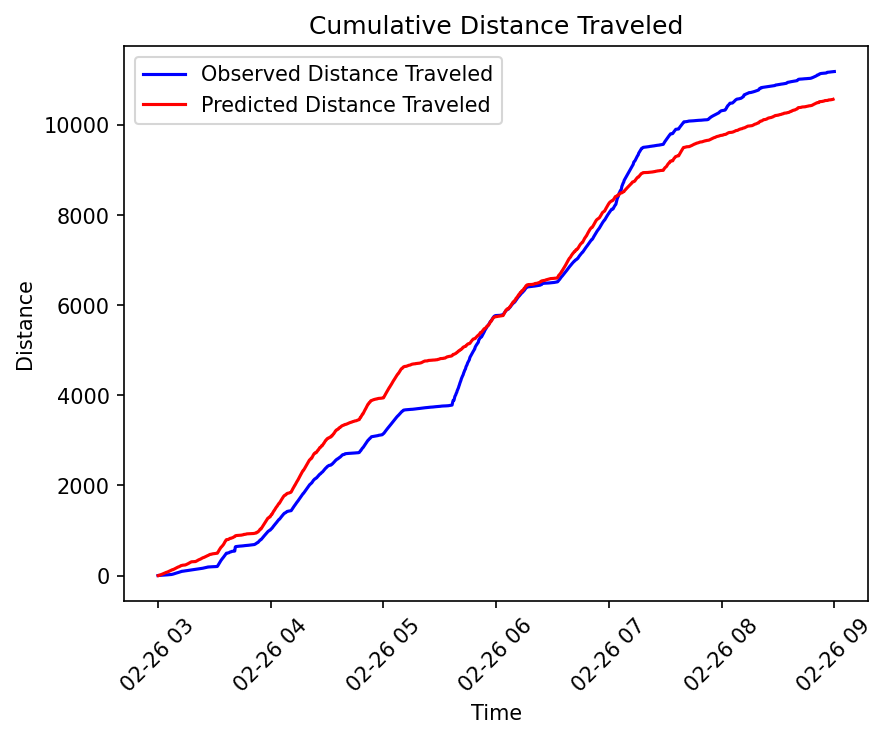

In [39]:
# Plot cumulative distance traveled
obs_dist = gps_pts['cum_dist']
obs_dt = gps_pts['datetime']
pred_dist = result_df['cum_dist']
pred_dt = result_df['datetime']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(obs_dt, obs_dist, linestyle='-', color='b', label='Observed Distance Traveled')
ax.plot(pred_dt, pred_dist,linestyle='-', color='r', label='Predicted Distance Traveled')
#plt.fill_between(obs_dt, gps_pts['cumsum_lwr'], gps_pts['cumsum_upr'])

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Distance')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Adding a title and legend
ax.set_title('Cumulative Distance Traveled')
ax.legend()

# Show plot
plt.show()

## Elevation Change

In [40]:
# Calc elevation change in GPS data using height above msl
gps_pts['delta_elev_msl'] = gps_pts['Height.above.msl'].diff()
gps_pts['cum_delta_elev_msl'] = gps_pts['delta_elev_msl'].cumsum()

# Calc elevation change in GPS data using formula
dist = np.array(gps_pts['euclidean_distance_step'])
slope = np.array(gps_pts['Slope1'])*math.pi/180
gps_pts['delta_elev_trig'] = dist * np.tan(slope)
gps_pts['cum_delta_elev_trig'] = gps_pts['delta_elev_trig'].cumsum()



In [43]:
active_periods.columns

Index(['valid_step', 'datetime', 'level_0', 'index', 'Acc_x', 'Acc_y', 'Acc_z',
       'Date', 'Time', 'location.lat', 'location.long', 'Height.above.msl',
       'UTM_E', 'UTM_N', 'Slope1', 'date_converted', 'time_converted', 'Gx',
       'Gy', 'Gz', 'DAx', 'DAy', 'DAz', 'pitch', 'roll', 'RAx', 'RAy', 'RAz',
       'FRAx', 'FRAy', 'FRAz', 'magnitude', 'mag_sd', 'activity_group',
       'active', 'thresh_z', 'falling_edges'],
      dtype='object')

In [44]:
# Merge step candidates with active_periods to get distance traveled
dists_slopes = pd.merge(active_periods, step_candidates[['distance_traveled','datetime']], on='datetime', how='left')
dists_slopes['date_floor'] = dists_slopes['datetime'].dt.floor('S')
dists_slopes = dists_slopes.groupby('date_floor').agg({
    'distance_traveled': 'sum',   # Sum of 'value1'
    'RAx': 'mean',
    'Gx': 'mean',
    'pitch':'mean',
    'activity_group':'first'
}).reset_index()

dists_slopes = dists_slopes.rename(columns={'date_floor' : 'datetime'})
dists_slopes = pd.merge(dists_slopes, gps_pts[['delta_elev_trig','delta_elev_msl','datetime','cum_delta_elev_trig','cum_delta_elev_msl']], on = "datetime", how = "left")
dists_slopes['distance_traveled'] = dists_slopes['distance_traveled'].fillna(0)

def model_predictions(collar_angle,data):

    # Predict slope
    ax = np.array(data['RAx'])
    gx = np.array(data['Gx'])
    data['slope_trig'] = np.arcsin((gx)/9.81)-collar_angle
    pred_slope = data['slope_trig']

    # Predict elevation change
    dist = np.array(data['distance_traveled'])
    slope = np.array(data['slope_trig'])    
    delta_elev = dist * np.tan(slope)
    return delta_elev

# Define the cost and objectie functions
def cost_function(params, data, actual):
    predictions = model_predictions(params, data)
    residuals = actual-predictions
    return np.sum((residuals)**2)

def objective(params):
    return cost_function(params,data,actual)

# Define perameter bounds for Differential Evolution (a type of genetic algorithm)
bounds = [(-0.008,-0.0065)] #  collar angle

In [45]:
dists_slopes

,datetime,distance_traveled,RAx,Gx,pitch,activity_group,delta_elev_trig,delta_elev_msl,cum_delta_elev_trig,cum_delta_elev_msl
0,2019-02-26 03:00:04,0.0,0.534071,0.218189,0.219506,1,0.002415,-2.0,0.009813,-2.0
1,2019-02-26 03:00:05,0.0,0.549547,0.214320,0.214986,1,0.001618,0.0,0.011431,-2.0
2,2019-02-26 03:00:06,0.0,0.535946,0.216241,0.216547,1,0.000000,0.0,0.011431,-2.0
3,2019-02-26 03:00:07,0.0,0.490676,0.218081,0.220013,1,0.000000,0.0,0.011431,-2.0
4,2019-02-26 03:00:08,0.0,0.473242,0.228105,0.228580,1,0.001793,0.0,0.013224,-2.0
...,...,...,...,...,...,...,...,...,...,...
21308,2019-02-26 08:59:56,0.0,0.636966,0.512247,0.529777,189,0.000000,2.0,365.787424,-4.0
21309,2019-02-26 08:59:57,0.0,0.632124,0.512796,0.530392,189,0.000000,0.0,365.787424,-4.0
21310,2019-02-26 08:59:58,0.0,0.589138,0.476860,0.493412,189,0.006699,0.0,365.794124,-4.0
21311,2019-02-26 08:59:59,0.0,0.529364,0.444113,0.460326,189,0.000000,0.0,365.794124,-4.0


In [46]:
# # Initialize columns
# dists_slopes['delta_elev_acc'] = -999
# dists_slopes['collar_angle'] = -999
# dists_slopes['slope_trig'] = -999

# # Find optimal parameters for each activity period and estimate slope

# for i in range(0,num_groups):
#     # get group number
#     group = activity_groups[i]
    
#     # get group data
#     group_data = dists_slopes[dists_slopes['activity_group'] == group]
#     data = group_data
#     actual = group_data['delta_elev']

#     # Run differential evolution aglorithm to estimate optimal parameter values
#     result = differential_evolution(objective,bounds,popsize=30,maxiter=5000,tol=1e-20,mutation=1.99,recombination=0.9)
#     #result = minimize(objective,x0=[0.3],method='L-BFGS-B', bounds=[(-np.pi, np.pi)])
#     print(result.x)
#     # Calculate elevation change from acc data

#     ax = np.array(group_data['RAx'])
#     gx = np.array(group_data['Gx'])
#     group_data['slope_trig'] = np.arcsin((gx)/9.81)-result.x[0]
    
#     dist = np.array(group_data['distance_traveled'])
#     slope = abs(np.array(group_data['slope_trig']))
        
#     group_data['delta_elev_acc'] = dist * np.tan(slope)
#     group_data['collar_angle'] = result.x[0]

#     # Join group results back to main results table
#     dists_slopes[dists_slopes['activity_group']==group] = group_data
    
# dists_slopes['cum_delta_elev_acc']= dists_slopes['delta_elev_acc'].cumsum()

In [47]:
group_data.columns

Index(['level_0', 'index', 'Acc_x', 'Acc_y', 'Acc_z', 'datetime', 'Date',
       'Time', 'location.lat', 'location.long', 'Height.above.msl', 'UTM_E',
       'UTM_N', 'Slope1', 'date_converted', 'time_converted', 'Gx', 'Gy', 'Gz',
       'DAx', 'DAy', 'DAz', 'pitch', 'roll', 'RAx', 'RAy', 'RAz', 'FRAx',
       'FRAy', 'FRAz', 'magnitude', 'mag_sd', 'activity_group', 'active',
       'thresh_z', 'falling_edges'],
      dtype='object')

In [62]:
# Optimization using delta_elev_msl
dists_slopes['delta_elev_acc_msl']=-999
dists_slopes['slope_trig_msl']=-999

# Find optimal parameters for each activity period and estimate slope

for i in range(0,num_groups):
    
    # get group number
    group = activity_groups[i]
    
    # get group data
    group_data = dists_slopes[dists_slopes['activity_group'] == group]
    data = group_data
    actual = group_data['delta_elev_msl']

    # Run differential evolution aglorithm to estimate optimal parameter values
    result_msl = differential_evolution(objective, bounds, popsize=30)
    
    # Calculate elevation change from acc data

    ax = np.array(group_data['RAx'])
    gx = np.array(group_data['Gx'])
    group_data['slope_trig_msl'] = np.arcsin((gx)/9.81)-result_msl.x[0]
    
    
    dist = np.array(group_data['distance_traveled'])
    slope = np.array(group_data['slope_trig_msl'])
        
    group_data['delta_elev_acc_msl'] = dist * np.tan(slope)
   
    # Join group results back to main results table
    dists_slopes[dists_slopes['activity_group']==group] = group_data
    
dists_slopes['cum_delta_elev_acc_msl'] = dists_slopes['delta_elev_acc_msl'].cumsum()

In [63]:
# Optimization using delta_elev_trig
dists_slopes['delta_elev_acc_trig']=-999
dists_slopes['slope_trig_trig']=-999

# Define the cost and objectie functions
def model_predictions(collar_angle,data):

    # Predict slope
    ax = np.array(data['RAx'])
    gx = np.array(data['Gx'])
    data['slope_trig'] = np.arcsin((gx)/9.81)-collar_angle
    pred_slope = data['slope_trig']

    # Predict elevation change
    dist = np.array(data['distance_traveled'])
    slope = abs(np.array(data['slope_trig']))    
    delta_elev = dist * np.tan(slope)
    return delta_elev

# Define the cost and objectie functions
def cost_function(params, data, actual):
    predictions = model_predictions(params, data)
    residuals = actual-predictions
    return np.sum((residuals)**2)

def objective(params):
    return cost_function(params,data,actual)

bounds = [(0.02,0.03)] #  collar angle

for i in range(0,num_groups):
    
    # get group number
    group = activity_groups[i]
    
    # get group data
    group_data = dists_slopes[dists_slopes['activity_group'] == group]
    data = group_data
    actual = group_data['delta_elev_trig']

    # Run differential evolution aglorithm to estimate optimal parameter values
    result_trig = differential_evolution(objective, bounds, popsize=30)
    # Calculate elevation change from acc data

    ax = np.array(group_data['RAx'])
    gx = np.array(group_data['Gx'])
    group_data['slope_trig_trig'] = np.arcsin((gx)/9.81)-result_trig.x[0]
    
    dist = np.array(group_data['distance_traveled'])
    slope = abs(np.array(group_data['slope_trig_trig']))
        
    group_data['delta_elev_acc_trig'] = dist * np.tan(slope)
   
    # Join group results back to main results table
    dists_slopes[dists_slopes['activity_group']==group] = group_data
    
dists_slopes['cum_delta_elev_acc_trig'] = dists_slopes['delta_elev_acc_trig'].cumsum()

In [64]:
# # Optimization using delta_elev_msl

# # Define data
# data = dists_slopes

# # Define observations
# actual = dists_slopes['delta_elev_msl']

# # Run differential evolution aglorithm to estimate optimal parameter values
# result_msl = differential_evolution(objective, bounds, popsize=30)

In [65]:
# # Optimization using delta_elev_trig

# # Define data
# data = dists_slopes

# # Define observations
# actual = dists_slopes['delta_elev_trig']

# # Define the cost and objectie functions
# def model_predictions(collar_angle,data):

#     # Predict slope
#     ax = np.array(data['RAx'])
#     gx = np.array(data['Gx'])
#     data['slope_trig'] = np.arcsin((gx)/9.81)-collar_angle
#     pred_slope = data['slope_trig']

#     # Predict elevation change
#     dist = np.array(data['distance_traveled'])
#     slope = abs(np.array(data['slope_trig']))    
#     delta_elev = dist * np.tan(slope)
#     return delta_elev

# # Define the cost and objectie functions
# def cost_function(params, data, actual):
#     predictions = model_predictions(params, data)
#     residuals = actual-predictions
#     return np.sum((residuals)**2)

# def objective(params):
#     return cost_function(params,data,actual)

# bounds = [(-2,2)] #  collar angle
# # Run differential evolution aglorithm to estimate optimal parameter values
# result_trig = differential_evolution(objective, bounds, popsize=30)

In [66]:
# # Calculate elevation change from acc data using collar angle obtained from delta_elev_msl optimization

# ax = np.array(dists_slopes['RAx'])
# gx = np.array(dists_slopes['Gx'])
# dists_slopes['slope_trig_msl'] = np.arcsin((gx)/9.81)-result_msl.x[0]

# dist = np.array(dists_slopes['distance_traveled'])
# slope = np.array(dists_slopes['slope_trig_msl'])


# dists_slopes['delta_elev_acc_msl'] = dist * np.tan(slope)
# dists_slopes['cum_delta_elev_acc_msl'] = dists_slopes['delta_elev_acc_msl'].cumsum()

# # Calculate elevation change from acc data using collar angle obtained from delta_elev_trig optimization

# ax = np.array(dists_slopes['RAx'])
# gx = np.array(dists_slopes['Gx'])
# dists_slopes['slope_trig_trig'] = np.arcsin((gx)/9.81)-result_trig.x[0]

# dist = np.array(dists_slopes['distance_traveled'])
# slope = abs(np.array(dists_slopes['slope_trig_trig']))


# dists_slopes['delta_elev_acc_trig'] = dist * np.tan(slope)
# dists_slopes['cum_delta_elev_acc_trig'] = dists_slopes['delta_elev_acc_trig'].cumsum()

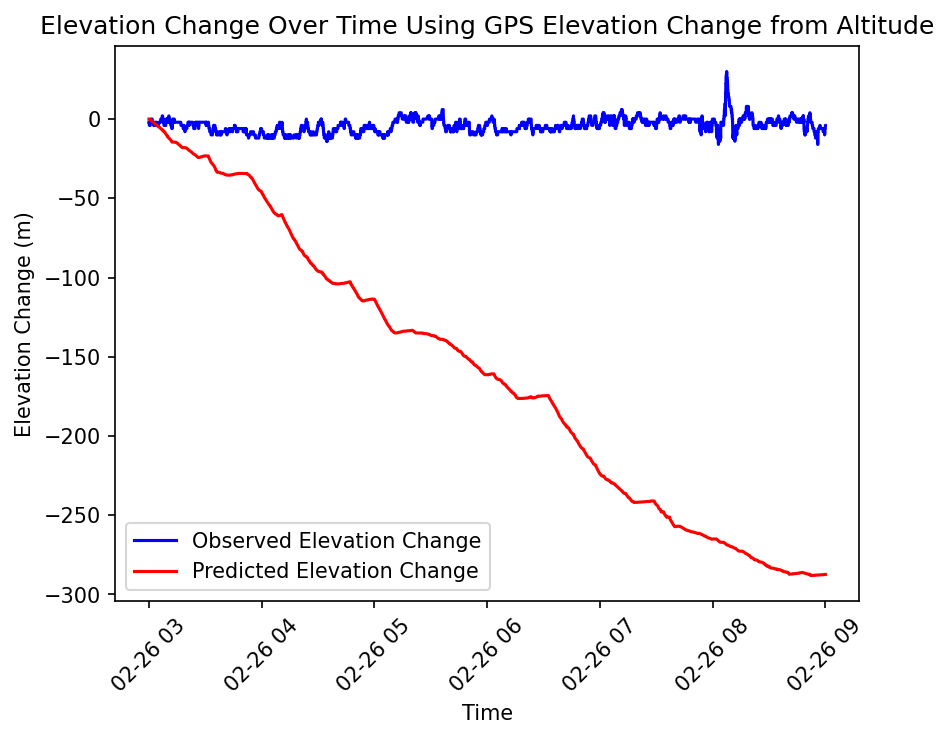

In [67]:
# Plot elevation changes
obs_delta = dists_slopes[dists_slopes['cum_delta_elev_msl'].notna()]['cum_delta_elev_msl']
obs_dt = dists_slopes[dists_slopes['cum_delta_elev_msl'].notna()]['datetime']
pred_delta = dists_slopes['cum_delta_elev_acc_msl']
pred_dt = dists_slopes['datetime']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(obs_dt, obs_delta, linestyle='-', color='b', label='Observed Elevation Change')
ax.plot(pred_dt, pred_delta,linestyle='-', color='r', label='Predicted Elevation Change')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Elevation Change (m)')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Adding a title and legend
ax.set_title('Elevation Change Over Time Using GPS Elevation Change from Altitude')
ax.legend()

# Show plot
plt.show()

In [68]:
result_trig

             message: Optimization terminated successfully.
             success: True
                 fun: 0.0022346855194751293
                   x: [ 3.000e-02]
                 nit: 10
                nfev: 332
          population: [[ 3.000e-02]
                       [ 2.995e-02]
                       ...
                       [ 2.999e-02]
                       [ 2.986e-02]]
 population_energies: [ 2.235e-03  2.237e-03 ...  2.235e-03  2.243e-03]

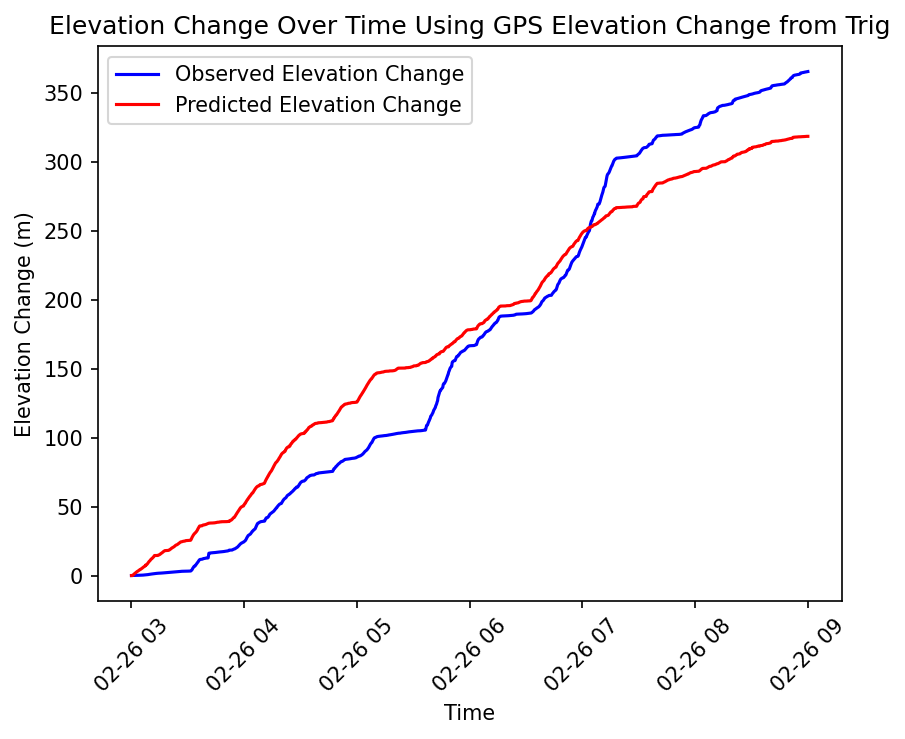

In [69]:
# Plot elevation changes
obs_delta = dists_slopes['cum_delta_elev_trig']
obs_dt = dists_slopes['datetime']
pred_delta = dists_slopes['cum_delta_elev_acc_trig']
pred_dt = dists_slopes['datetime']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(obs_dt, obs_delta, linestyle='-', color='b', label='Observed Elevation Change')
ax.plot(pred_dt, pred_delta,linestyle='-', color='r', label='Predicted Elevation Change')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Elevation Change (m)')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Adding a title and legend
ax.set_title('Elevation Change Over Time Using GPS Elevation Change from Trig')
ax.legend()

# Show plot
plt.show()

In [70]:
dists_slopes.columns

Index(['datetime', 'distance_traveled', 'RAx', 'Gx', 'pitch', 'activity_group',
       'delta_elev_trig', 'delta_elev_msl', 'cum_delta_elev_trig',
       'cum_delta_elev_msl', 'delta_elev_acc_msl', 'slope_trig_msl',
       'cum_delta_elev_acc_msl', 'delta_elev_acc_trig', 'slope_trig_trig',
       'cum_delta_elev_acc_trig', 'energy_msl', 'cum_energy_msl',
       'energy_trig', 'cum_energy_trig'],
      dtype='object')

## Estimate Energy Expenditure
- Energy expenditure can be estimated using the same activation-relaxation cycling model (ARC model) employed by Berti et al. under the ENERSCAPE framework
- According to the ARC model, the energetic cost of transport is a function of distance traveled, slope of the ground, and body mass of the animal. Distance traveled and slope of the ground can be obtained using the algorithm above.

In [71]:
dists_slopes

,datetime,distance_traveled,RAx,Gx,pitch,activity_group,delta_elev_trig,delta_elev_msl,cum_delta_elev_trig,cum_delta_elev_msl,delta_elev_acc_msl,slope_trig_msl,cum_delta_elev_acc_msl,delta_elev_acc_trig,slope_trig_trig,cum_delta_elev_acc_trig,energy_msl,cum_energy_msl,energy_trig,cum_energy_trig
0,2019-02-26 03:00:04,0.0,0.534071,0.218189,0.219506,1,0.002415,-2.0,0.009813,-2.0,0.0,0.002243,0.000000,0.0,0.002243,0.000000,0.0,0.000000,0.0,0.00000
1,2019-02-26 03:00:05,0.0,0.549547,0.214320,0.214986,1,0.001618,0.0,0.011431,-2.0,0.0,0.001849,0.000000,0.0,0.001849,0.000000,0.0,0.000000,0.0,0.00000
2,2019-02-26 03:00:06,0.0,0.535946,0.216241,0.216547,1,0.000000,0.0,0.011431,-2.0,0.0,0.002045,0.000000,0.0,0.002045,0.000000,0.0,0.000000,0.0,0.00000
3,2019-02-26 03:00:07,0.0,0.490676,0.218081,0.220013,1,0.000000,0.0,0.011431,-2.0,0.0,0.002232,0.000000,0.0,0.002232,0.000000,0.0,0.000000,0.0,0.00000
4,2019-02-26 03:00:08,0.0,0.473242,0.228105,0.228580,1,0.001793,0.0,0.013224,-2.0,0.0,0.003254,0.000000,0.0,0.003254,0.000000,0.0,0.000000,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21308,2019-02-26 08:59:56,0.0,0.636966,0.512247,0.529777,189,0.000000,2.0,365.787424,-4.0,0.0,0.032241,-287.417229,0.0,0.022241,318.770035,0.0,2291.691542,0.0,1011.38418
21309,2019-02-26 08:59:57,0.0,0.632124,0.512796,0.530392,189,0.000000,0.0,365.787424,-4.0,0.0,0.032297,-287.417229,0.0,0.022297,318.770035,0.0,2291.691542,0.0,1011.38418
21310,2019-02-26 08:59:58,0.0,0.589138,0.476860,0.493412,189,0.006699,0.0,365.794124,-4.0,0.0,0.028629,-287.417229,0.0,0.018629,318.770035,0.0,2291.691542,0.0,1011.38418
21311,2019-02-26 08:59:59,0.0,0.529364,0.444113,0.460326,189,0.000000,0.0,365.794124,-4.0,0.0,0.025287,-287.417229,0.0,0.015288,318.770035,0.0,2291.691542,0.0,1011.38418


In [72]:
# Set body mass
body_mass = 200

dist = np.array(dists_slopes['distance_traveled'].iloc[1:])
slope = np.array(dists_slopes['slope_trig_msl'].iloc[0:-1])
term1 = 8 * math.pow(body_mass,-0.34)
term2 = 50 * (1 + np.sin(2*slope-(74*math.pi/180))) * math.pow(body_mass,-0.12)
Ecot = term1 + term2
E = Ecot * body_mass * dist / 4184
dists_slopes['energy_msl'] = np.append([0],E)
dists_slopes['cum_energy_msl'] = dists_slopes['energy_msl'].cumsum()

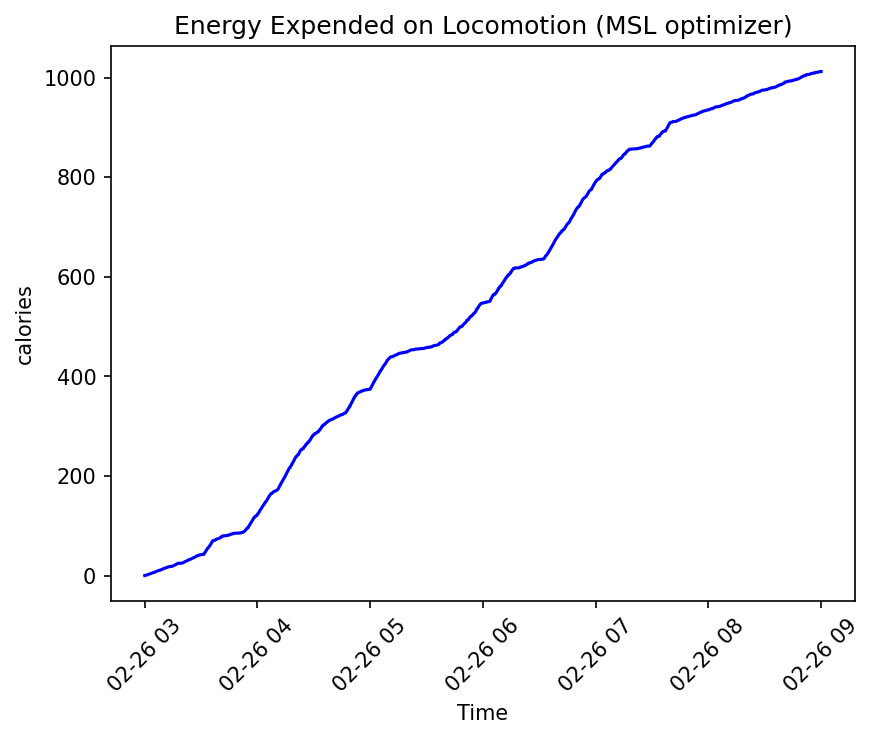

In [73]:
# PLOT CUMULATIVE ENERGY EXPENDITURE

energy = dists_slopes['cum_energy_msl']
#energy = steps['distance_traveled']
dt = dists_slopes['datetime']

# Create a 3D plot
fig = plt.figure()
ax1 = fig.add_subplot(111)

# Plot the trajectory
ax1.plot(dt, energy, linestyle='-', color='blue', label='Cumulative Energy Expenditure')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Setting labels
ax1.set_xlabel('Time')
ax1.set_ylabel('calories')

# Adding a title and legend
ax1.set_title('Energy Expended on Locomotion (MSL optimizer)')
ax.legend()

# Show plot
plt.show()

In [74]:
# Set body mass
body_mass = 200

dist = np.array(dists_slopes['distance_traveled'].iloc[1:])
slope = np.array(dists_slopes['slope_trig_trig'].iloc[0:-1])
term1 = 8 * math.pow(body_mass,-0.34)
term2 = 50 * (1 + np.sin(2*slope-(74*math.pi/180))) * math.pow(body_mass,-0.12)
Ecot = term1 + term2
E = Ecot * body_mass * dist / 4184
dists_slopes['energy_trig'] = np.append([0],E)
dists_slopes['cum_energy_trig'] = dists_slopes['energy_trig'].cumsum()

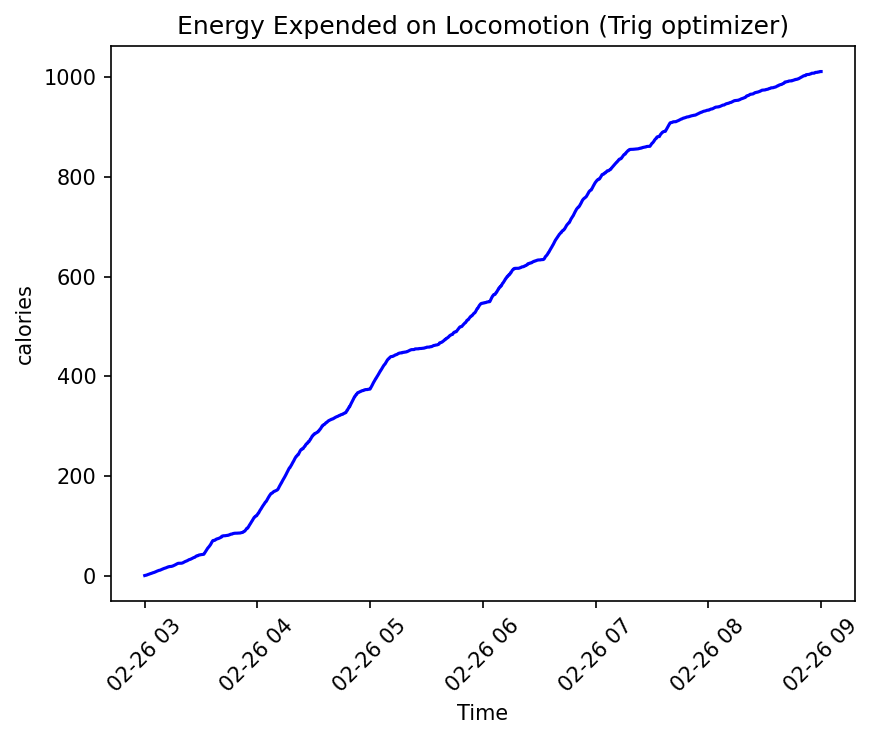

In [75]:
# PLOT CUMULATIVE ENERGY EXPENDITURE

energy = dists_slopes['cum_energy_trig']
#energy = steps['distance_traveled']
dt = dists_slopes['datetime']

# Create a 3D plot
fig = plt.figure()
ax1 = fig.add_subplot(111)

# Plot the trajectory
ax1.plot(dt, energy, linestyle='-', color='blue', label='Cumulative Energy Expenditure')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Setting labels
ax1.set_xlabel('Time')
ax1.set_ylabel('calories')

# Adding a title and legend
ax1.set_title('Energy Expended on Locomotion (Trig optimizer)')
ax.legend()

# Show plot
plt.show()